# Introduction to PINNs
### The static, linear Euler-Bernoulli beam

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Author: Jasper O. Schommartz

---

#### In this notebook, you will...

* learn to explain the fundamental structure of PINNs.
* calibrate a PINN for the linear Euler-Bernoulli cantilever beam.
* modify boundary conditions in PINN calibration.
* experience the importance of non-dimensionalization on PINN calibration.

In [3]:
# Run this cell is you are using Google Colab
!git clone https://github.com/CPSHub/LecturePhysicsAwareML.git
%cd LecturePhysicsAwareML/PINNs
%pip install -e .

Cloning into 'LecturePhysicsAwareML'...
remote: Enumerating objects: 670, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 670 (delta 155), reused 217 (delta 96), pack-reused 391 (from 1)
Receiving objects: 100% (670/670), 97.63 MiB | 27.58 MiB/s, done.
Resolving deltas: 100% (266/266), done.
/home/jasper/git/lecturephysicsawareml/PINNs/notebooks/LecturePhysicsAwareML/PINNs
Obtaining file:///home/jasper/git/lecturephysicsawareml/PINNs/notebooks/LecturePhysicsAwareML/PINNs
ERROR: file:///home/jasper/git/lecturephysicsawareml/PINNs/notebooks/LecturePhysicsAwareML/PINNs does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Run this cell, if you are working locally
%cd ..
%pip install -e .

/home/jasper/git/lecturephysicsawareml/PINNs/notebooks/LecturePhysicsAwareML
Obtaining file:///home/jasper/git/lecturephysicsawareml/PINNs/notebooks/LecturePhysicsAwareML
ERROR: file:///home/jasper/git/lecturephysicsawareml/PINNs/notebooks/LecturePhysicsAwareML does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1. Theory

### 1.1 Nonlinear Euler-Bernoulli Beam

In this task we consider a linear Euler-Bernoulli beam (LEBB).
The mechanical behavior of the linear beam is decribed by a fourth order differential equation, which reads

$$
(1) \quad\quad\quad EI w^{(4)} = q(x).
$$

Here, $w$ is the vertical displacement and $q(x)$ denotes a transversal line load depending on the horizontal location $x$. The Young's modulus and the moment of inertia are denoted by $E$ and $I$, respectively. For the scope of this work we **consider only constant line loads**, i.e, $q(x) = q_0$.


<img src="../img/beam.png" alt="Beam Image" width="600">

For the cantilever beam shown in the image above. The boundary conditions read

$$
w(0) = w'(0) = 0
$$

and the Neumann boundary conditions read

$$
Q(L) = F,\quad M(L) = 0.
$$

### 1.2 Non-dimensionalization

It has been reported in literature, that non-dimensionlizing PDEs before PINN calibration can improve convergence [[1][Wang2023]]. For the LEBB, problems with dimensionality arise depending on the choise of Young's modulus $E$, moment of inertia $L$ and beam length $L$.

Equation (1) may be non-dimentionalized as follows: First we define some dependent non-dimensional variables $\tilde{x}$, $\tilde{w}$, and $\tilde{q}$, which are realated to their dimensional counter parts as

$$
(2)\quad\quad x = x_0 \tilde{x}, \quad w = w_0 \tilde{w},\quad q = q_0 \tilde{q}
$$

The derivatives w.r.t. $w$ consequently follow as

$$
(3) \quad\quad \partial_x w = \frac{w_0}{x_0} \partial_{\tilde{x}} \tilde{w},\quad \partial_{x^2} w = \frac{w_0}{x_0^2} \partial_{\tilde{x}^2} \tilde{w},\quad \partial_{x^3} w = \frac{w_0}{x_0^3} \partial_{\tilde{x}^3} \tilde{w},\quad \partial_{x^4} w = \frac{w_0}{x_0^4} \partial_{\tilde{x}^4} \tilde{w}.
$$

By inserting Equations (2) and (3) into (1) assuming a constant line load and doing some refomulation we obtain

$$
\partial_{\tilde{x}^4} \tilde{w} = \frac{x_0^4}{EI w_0} q_0.
$$

From this we can choose $x_0$, $w_0$ and $q_0$ in different ways. First we set $x_0 = L$, which seems like a reasonable choice. If there is no line loas, we choose $q_0 = 1$. Otherwise $q_0$ takes the value of the constant line load. In order to set all factors to 1, we choose

$$
w_0 = \frac{q_0 L^4}{EI}
$$

With this, the bending moment $M = -EI \partial{x^2} w$ and the transversal force $Q = -EI \partial{x^3} w$ may be non-dimensionalized as

$$
\tilde{M} = \frac{M}{q_0 L^2}, \quad \text{and} \quad \tilde{Q} = \frac{Q}{q_0 x_0}
$$


### 1.3 PINN model

<img src="../img/pinn_lebb.png" alt="PINN LEBB" width=600>

The PINN architecture shown above is used in this task. Thereby a feed forward neural network (FFNN) is used to map from a collocation point $x$ to the displacement $w$. The PINN is calibrated by minimizing the residual of Equation (1) and well as the related boundary conditions. Hence, the physics is introduced in a weak manner. Futhermore, the PINN does not require any data for calibration, as the PDE solution is uniquely characterized by Equation (1) and the boudary condition.

The loss function consists of three parts. It reads

$$
\mathcal{L} = \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{res}} + \mathcal{L}_{\text{BC}}
$$

Here, $\mathcal{L}_{data}$, denotes the error on a set of labeled data, $\mathcal{L}_{res}$ denotes the residual of Equation (1), and $\mathcal{L}_{BC}$ denotes the residual of the Dirichlet and Neumann boundary conditions. **In this simple task we do not consider any data loss**. In pratice, weighting of the different loss terms can be an issue, especially for high-dimensional problems. Therefore, different methods for loss and gradient weighting have been developed [[1][Wang2023]], which are out of the scope of this tutorial.

[Wang2023]: https://arxiv.org/abs/2308.08468

## 2. PINN Calibration
### 2.1 Definition of Boundary Conditions

You can use this section to define arbitrary boundary conditions on the LEBB.

In [5]:
import jax.numpy as jnp
from paml_pinns.lebb import Config, get_data_decorator


@get_data_decorator
def get_data(config: Config):
    if config.bc_case == 0:
        w_bc_coords = jnp.array([0.0])
        w_bc_values = jnp.array([0.0])
        w_x_bc_coords = jnp.array([0.0])
        w_x_bc_values = jnp.array([0.0])
        M_bc_coords = jnp.array([config.L])
        M_bc_values = jnp.array([0.0])
        Q_bc_coords = jnp.array([config.L])
        Q_bc_values = jnp.array([config.F])
    elif config.bc_case == 1:
        # Start of task scope
        ######################
        pass  # remove this for testing
        # w_bc_coords =
        # w_bc_values =
        # w_x_bc_coords =
        # w_x_bc_values =
        # M_bc_coords =
        # M_bc_values =
        # Q_bc_coords =
        # Q_bc_values =
        ######################
        # End of task scope
    else:
        NotImplementedError(
            "Data generation is not implemented for these boundary conditions."
        )

    bc = {
        "w_bc_coords": w_bc_coords,
        "w_bc_values": w_bc_values,
        "w_x_bc_coords": w_x_bc_coords,
        "w_x_bc_values": w_x_bc_values,
        "M_bc_coords": M_bc_coords,
        "M_bc_values": M_bc_values,
        "Q_bc_coords": Q_bc_coords,
        "Q_bc_values": Q_bc_values,
    }
    return bc


### 2.2 Configuration of Beam Properties

In this section, the properties of the beam can be defined for the boundary condition cases above. Note that line loads are considered to be constant.

In [ ]:
from paml_pinns.lebb import get_config_decorator
from typing import Tuple


@get_config_decorator
def get_config(bc_case: int) -> Tuple[float, float, float, float]:
    if bc_case == 0:
        EI = 1e6
        L = 1.0
        F = 1.0
        q = 0.0
    elif bc_case == 1:
        EI = 1e6
        L = 1.0
        F = 0.0  # Unused dummy
        q = 1.0
    else:
        raise NotImplementedError(
            "No configuration implemented for these boundary conditions."
        )

    return EI, L, F, q

### 2.3 Data Generation and Model Creation

Here, we generate input and solution data for the LEBB. This is only possible, since Equation (1) can be solved analytically. However, **note** that solution data is not required for PINN calibration. Next, and instance of the PINN model is create using a pseudo-random seed.

In [7]:
import jax
from paml_pinns.lebb import PINN


config = get_config(bc_case=0, non_dim=True)
x, y, bc, EI, L, q = get_data(config)
weights = {"w_bc": 1.0, "w_x_bc": 1.0, "M_bc": 1.0, "Q_bc": 1.0, "rw": 1.0}

key = jax.random.PRNGKey(1234)
model = PINN(EI, L, q, bc, key=key)


### 2.4 Model Calibration and Evaluation

The model is calibrated and evaluated. **Note**, that the solution data `y` is not passed to the `train` function. Hence, the PINN is trained exclusively using residuals.

Step: 0,	Loss: 1.0942822694778442
Step: 1000,	Loss: 0.00023888458963483572
Step: 2000,	Loss: 8.831000741338357e-05
Step: 3000,	Loss: 3.284202830400318e-05
Step: 4000,	Loss: 3.1194758776109666e-05
Step: 5000,	Loss: 3.515577191137709e-05
Step: 6000,	Loss: 3.87540967494715e-05
Step: 7000,	Loss: 1.9147646526107565e-05
Step: 8000,	Loss: 1.1367482329660561e-05
Step: 9000,	Loss: 6.400741767720319e-06
Step: 10000,	Loss: 4.835330855712527e-06
Step: 11000,	Loss: 3.1586380373482825e-06
Step: 12000,	Loss: 3.375708956809831e-06
Step: 13000,	Loss: 2.4730225050006993e-05
Step: 14000,	Loss: 1.831925487749686e-06
Step: 15000,	Loss: 2.6013110527856043e-06
Step: 16000,	Loss: 1.3180953146729735e-06
Step: 17000,	Loss: 2.122948217220255e-06
Step: 18000,	Loss: 2.082606670228415e-06
Step: 19000,	Loss: 5.664700211127638e-07
Step: 20000,	Loss: 1.5687442100897897e-06
Step: 21000,	Loss: 1.7388221067449194e-06
Step: 22000,	Loss: 6.147200224404514e-07
Step: 23000,	Loss: 2.2483543489215663e-06
Step: 24000,	Loss: 2.8

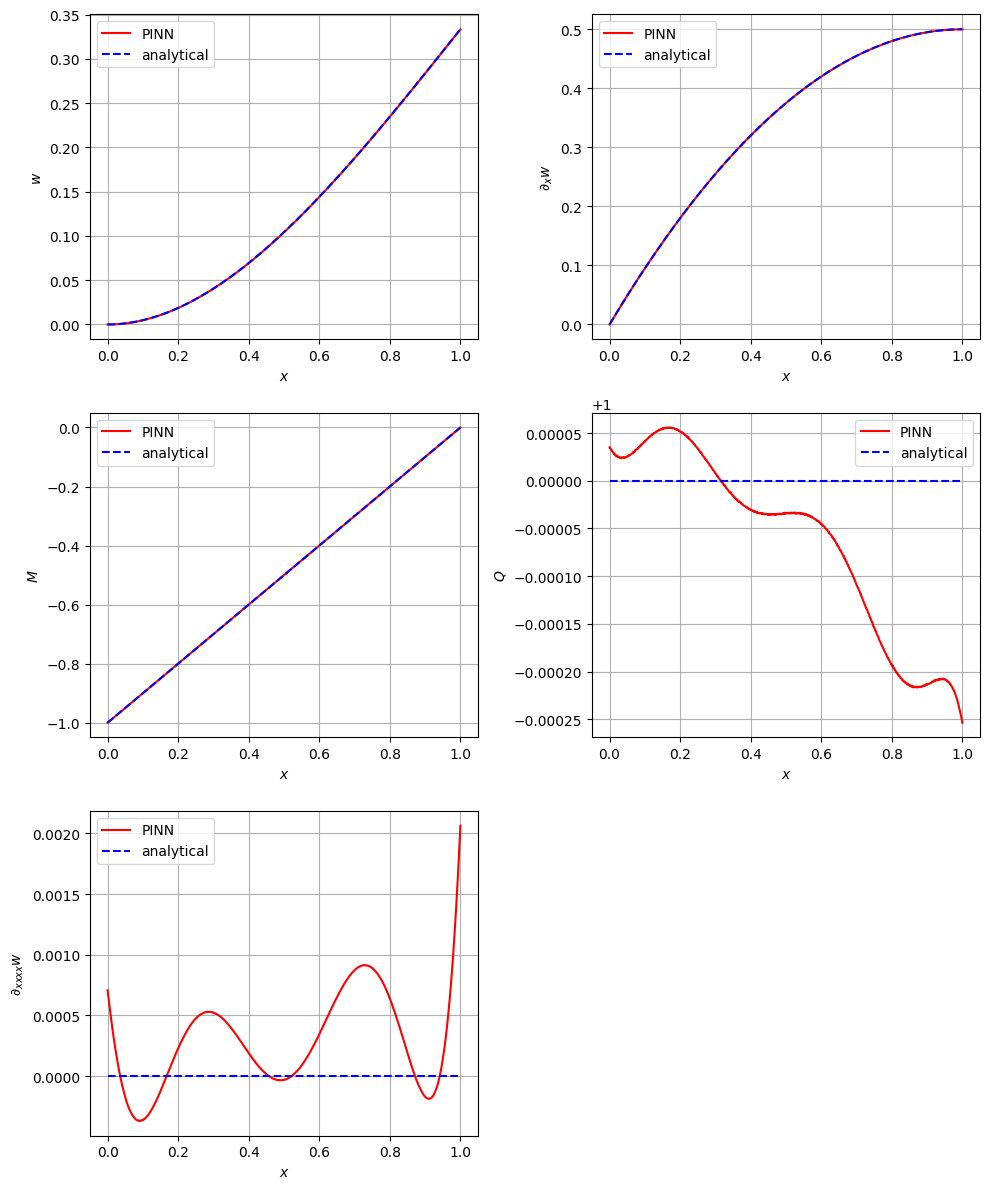

In [8]:
from paml_pinns import train
from paml_pinns.lebb import evaluate


model = train(model, x, weights, steps=50_000)
evaluate(model, x, y)

## 3 Tasks

### Task 1: Effect of Non-Dimensionalization

For `bc_case=0`, ...

a) Set `EI=1e6`, and `non_dim=False`. Can the model approximate the solution?

b) Now set the `EI = 1.0`. Can the model approximate the solution now?

c) Set `EI=1e6` again and set `non_dim=True`. What different to you observe compared to a)? Explain.  

### Task 2: Implementation of Boundary Conditions

Implement the boundary conditions for `bc_case=1` within `get_data()`. Next, calibrate the PINN and test your implementation against the analytical solution. Note, boundary conditions can be set equal to `None`to be ignored.

*Solution proposal:*

In [9]:
import jax.numpy as jnp

from paml_pinns.lebb import Config, get_data_decorator


@get_data_decorator
def get_data(config: Config):
    if config.bc_case == 1:
        w_bc_coords = jnp.array([0.0, config.L])
        w_bc_values = jnp.array([0.0, 0.0])
        w_x_bc_coords = None
        w_x_bc_values = None
        M_bc_coords = jnp.array([0.0, config.L])
        M_bc_values = jnp.array([0.0, 0.0])
        Q_bc_coords = None
        Q_bc_values = None
    else:
        NotImplementedError(
            "Data generation is not implemented for these boundary conditions."
        )

    bc = {
        "w_bc_coords": w_bc_coords,
        "w_bc_values": w_bc_values,
        "w_x_bc_coords": w_x_bc_coords,
        "w_x_bc_values": w_x_bc_values,
        "M_bc_coords": M_bc_coords,
        "M_bc_values": M_bc_values,
        "Q_bc_coords": Q_bc_coords,
        "Q_bc_values": Q_bc_values,
    }
    return bc